# QUESTÃO 2:

Escreva um programa que simule o desempenho de BER de um sistema de comunicação que utiliza o código convolucional mostrado na figura abaixo com decodificação via algoritmo de Viterbi, modulação QPSK (com mapeamento Gray) e canal AWGN.  

Considere a transmissão de 1000 quadros, cada qual contendo ℎ = 200 blocos de informação e relação sinal-ruído de bit (E_b/N_0) variando de -1 a 7 "dB" com passo 1 "dB". Compare com o caso não codificado.

In [1]:
# Importando as bibliotecas necessárias
import numpy as np
import komm as komm
import matplotlib.pyplot as plt

# Imprimindo a versão da biblioteca
print("Komm version: ", komm.__version__)
print("Numpy version: ", np.__version__)


Komm version:  0.9.1
Numpy version:  2.1.3


In [ ]:
# Quantidade de blocos: 
h = 200

# Polinômios geradores
generator_matrices = [[0b1001111, 0b1101101]]

# Ordem da modulação PSK
M = 4

# Número de quadros
Nframes = 1000

# Faixa de valores de Eb/N0, com passo 1 dB
# EBN0_Range = np.arange(-1, 7, 1)

# NOTA: Neste ponto foi utilizado um passo de 0.5 dB para melhorar a resolução do gráfico
EBN0_Range = np.arange(-1, 10, 0.5)

In [ ]:
# Modulação PSK
modulator = komm.PSKModulation(M, labeling='reflected')

# Codificador convolucional
conv_encoder = komm.ConvolutionalCode(
    feedforward_polynomials=generator_matrices)

# Código de bloco com terminação em zero
block_code = komm.TerminatedConvolutionalCode(
    conv_encoder, h, mode='zero-termination')

# Criando instância de codificador e decodificador de bloco
encoder = komm.BlockEncoder(block_code)
decoder = komm.BlockDecoder(block_code, method='viterbi_hard')

In [4]:
# Inicializando o vetor de BER para transmissão sem codificação
BER_original = np.zeros(len(EBN0_Range))
# Inicializando o vetor de BER para o código convolucional
BER_conv = np.zeros(len(EBN0_Range))

# Loop para cada valor de Eb/N0
for i, SNR in enumerate(EBN0_Range):
    # Criando um vetor de bits aleatórios
    bits = np.random.randint(0, 2, h * Nframes)

    # Codificação da mensagem
    encoded_bits = encoder(bits)

    # Modulação da mensagens codificada e original
    modulated_bits = modulator.modulate(encoded_bits)
    modulated_bits_original = modulator.modulate(bits)

    # Calculando a SNR
    snr = 10 ** (SNR / 10)
    awgn = komm.AWGNChannel(snr=snr, signal_power="measured")

    # Adicionando ruído aos sinais modulados
    noisy_signal = awgn(modulated_bits)
    noisy_signal_original = awgn(modulated_bits_original)

    # Demodulando o sinal recebido
    demodulated_signal = modulator.demodulate(
        noisy_signal)
    demodulated_signal_original = modulator.demodulate(
        noisy_signal_original)

    # Decodificando a mensagem (codificada)
    decoded_bits = decoder(demodulated_signal)

    # Calculando a BER para os sinais codificados e originais
    BER_conv[i] = np.mean(
        bits != decoded_bits[:len(bits)])
    BER_original[i] = np.mean(
        bits != demodulated_signal_original[:len(bits)])


print("BER_conv     | BER_original")
for conv, original in zip(BER_conv, BER_original):
    print(f"{conv:<12} | {original}")

BER_conv     | BER_original
0.41856      | 0.187225
0.383685     | 0.17219
0.34454      | 0.1598
0.292635     | 0.1444
0.23308      | 0.13079
0.1703       | 0.11773
0.107525     | 0.10561
0.060375     | 0.09092
0.027515     | 0.07971
0.013075     | 0.066325
0.005425     | 0.05694
0.002095     | 0.047835
0.00042      | 0.036935
0.00017      | 0.03001
1.5e-05      | 0.023275
0.0          | 0.017625
0.0          | 0.01275
0.0          | 0.0088
0.0          | 0.00616
0.0          | 0.00379
0.0          | 0.002485
0.0          | 0.00136


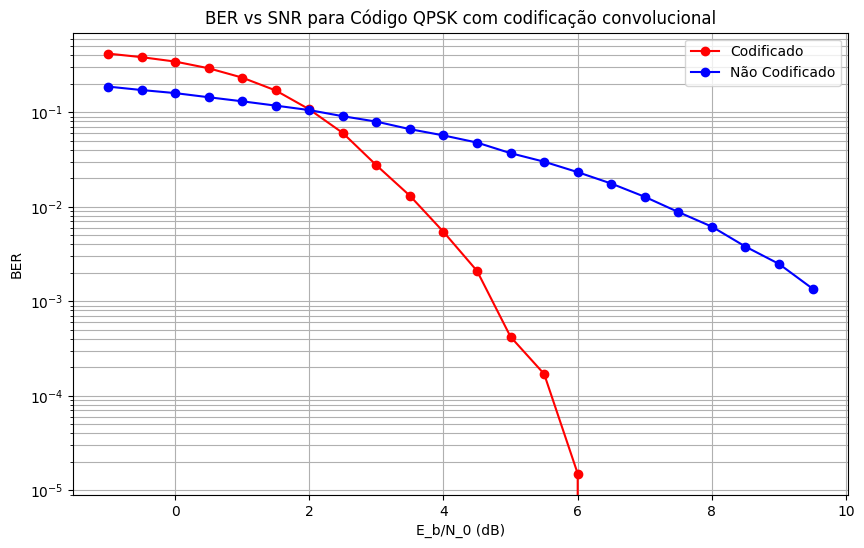

In [6]:
plt.figure(figsize=(10, 6))
plt.semilogy(EBN0_Range, BER_conv, '-o', label='Codificado', color="red")
plt.semilogy(EBN0_Range, BER_original, '-o', label='Não Codificado', color="blue")

plt.xlabel('E_b/N_0 (dB)')
plt.ylabel("BER")
plt.title('BER vs SNR para Código QPSK com codificação convolucional')

plt.legend()
plt.grid(True, which="both")  # Grid em ambas escalas
plt.show()